In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler,normalize
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score,RepeatedKFold
from sklearn.metrics import r2_score,accuracy_score,mean_absolute_error,mean_squared_error

In [2]:
def datapreprocess(df):
    df['day']=df['datetime'].apply(lambda x:datetime.strptime(x,'%m/%d/%Y %H:%M').day)
    df['month']=df['datetime'].apply(lambda x:datetime.strptime(x,'%m/%d/%Y %H:%M').month)
    df['year']=df['datetime'].apply(lambda x:datetime.strptime(x,'%m/%d/%Y %H:%M').year)
    df['hour']=df['datetime'].apply(lambda x:datetime.strptime(x,'%m/%d/%Y %H:%M').hour)
    df.drop('datetime',axis=1,inplace=True)
    for col in ['season', 'holiday', 'workingday', 'month','hour','weather','day']:
        df[col] = df[col].astype('category')
    weather_map={'Clear + Few clouds':'CF','Light Snow, Light Rain':'LSLR','Mist + Cloudy':'MC','Heavy Rain + Thunderstorm':'HRT'}
    df['weather'] = df['weather'].apply(lambda x : weather_map.get(x.strip()))
    

In [3]:
train=pd.read_csv('train.csv')
datapreprocess(train)
train_laebl=pd.read_csv('train_label.csv',header=None)
train_laebl.rename(columns={0:'Total_bookings'},inplace=True)
train['Total_bookings']=train_laebl['Total_bookings']


Univariate Analysis

In [93]:
train['holiday'].value_counts()[1]/len(train['holiday'])

0.02847955902618282

Holiday days are very few in number . Non holidays ( 0 ) are dominating,Low Variance. so it may not have any impact on dependent variable

In [98]:
train['weather'].value_counts()

 Clear + Few clouds            5753
 Mist + Cloudy                 2276
 Light Snow, Light Rain         678
 Heavy Rain + Thunderstorm        1
Name: weather, dtype: int64

IN weather , heavy Rain + Thunderstorm seems to be an outlier

In [4]:
cat_cols=['season', 'holiday', 'workingday', 'month','hour','weather','day']

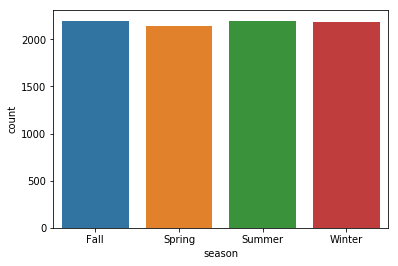

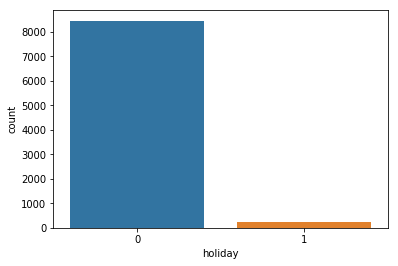

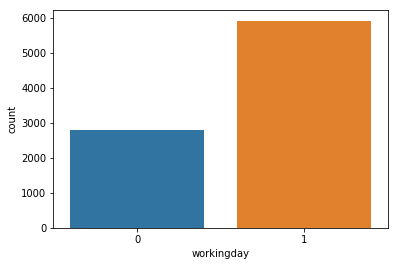

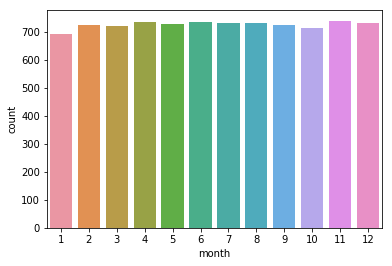

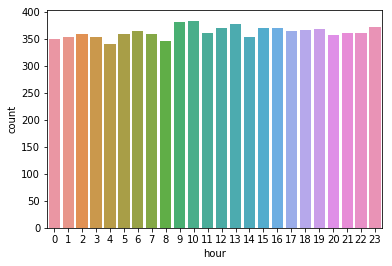

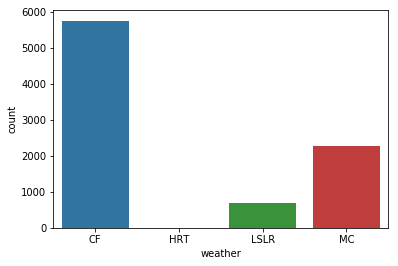

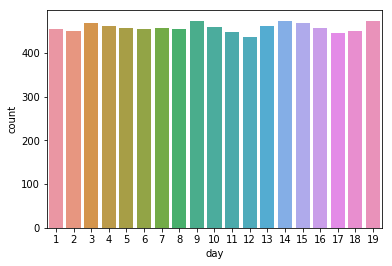

In [11]:
for col in cat_cols:
    plt.figure()
    sns.countplot(col,data=train)

In [5]:
continuous_cols=['temp','atemp','humidity','windspeed']

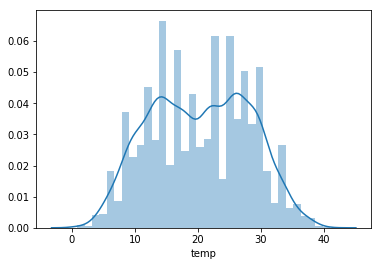

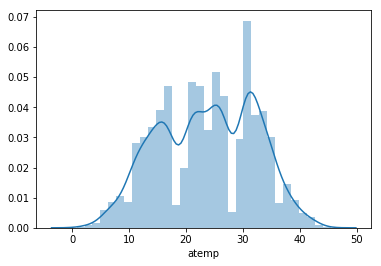

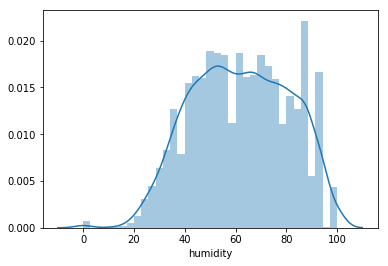

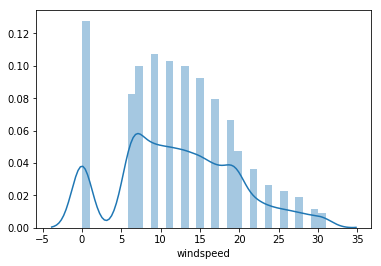

In [61]:
for contcol in continuous_cols:
    plt.figure()
    sns.distplot(train[contcol],hist=True)

Bi Variate Visualizations

<Figure size 432x288 with 0 Axes>

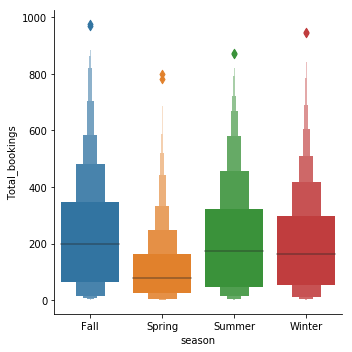

<Figure size 432x288 with 0 Axes>

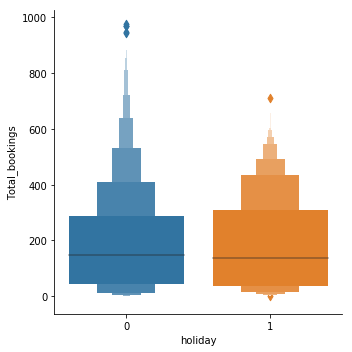

<Figure size 432x288 with 0 Axes>

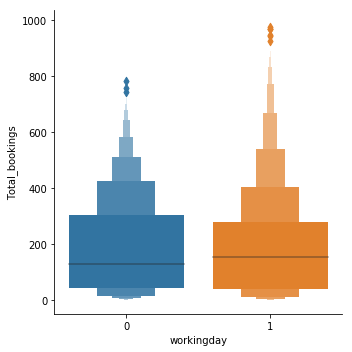

<Figure size 432x288 with 0 Axes>

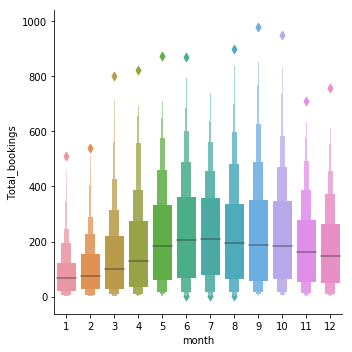

<Figure size 432x288 with 0 Axes>

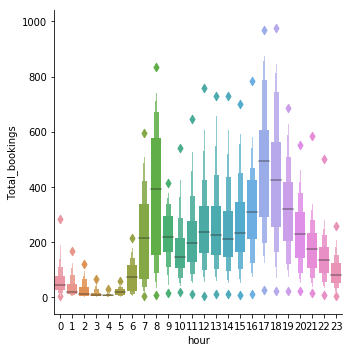

<Figure size 432x288 with 0 Axes>

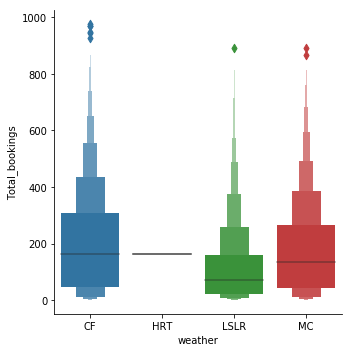

<Figure size 432x288 with 0 Axes>

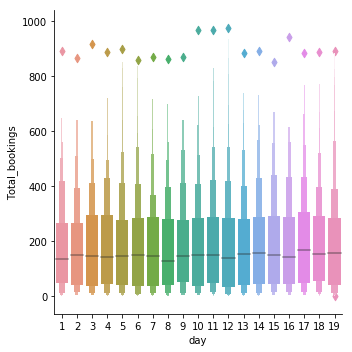

In [67]:
y=train['Total_bookings']
for col in cat_cols:
    plt.figure()
    sns.catplot(x=col,y='Total_bookings',data=train,kind='boxen')
    #sns.countplot(x=col,data=train,hue=y)

day , holiday , working day seems to have no effect on Total_booking

<Figure size 432x288 with 0 Axes>

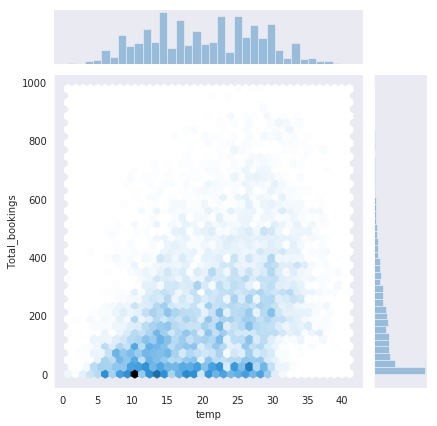

<Figure size 432x288 with 0 Axes>

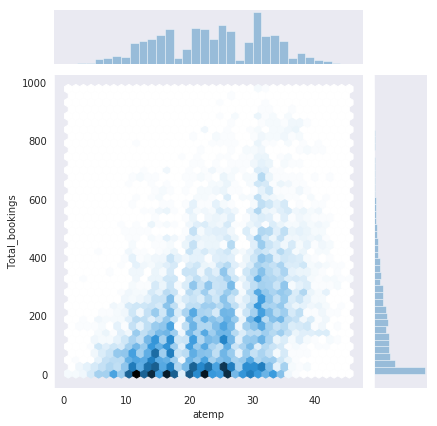

<Figure size 432x288 with 0 Axes>

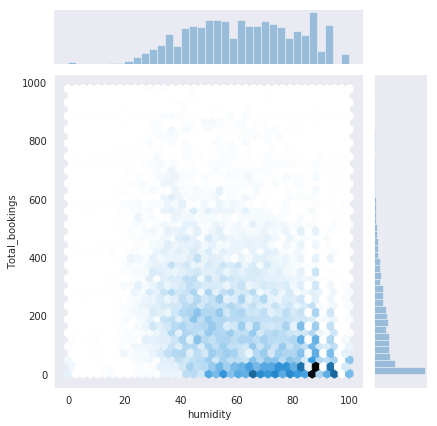

<Figure size 432x288 with 0 Axes>

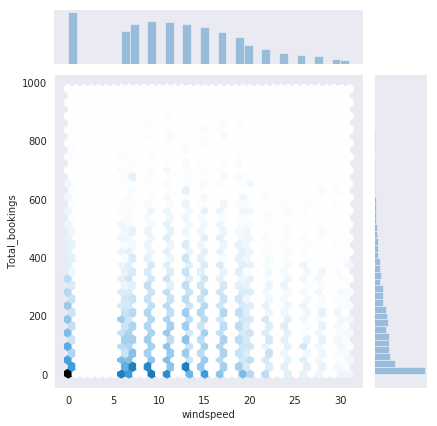

In [62]:
#y=train_laebl['Total_booking']
for contcol in continuous_cols:
    plt.figure()
    #sns.scatterplot(x=train['humidity'],y=y)
    with sns.axes_style('dark'):
        sns.jointplot(x=train[contcol],y=train_laebl['Total_bookings'], kind="hex");
 
    

There are no missing values in the dataset

In [20]:
train.isnull().sum()

season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Total_booking    0
day              0
month            0
year             0
hour             0
dtype: int64

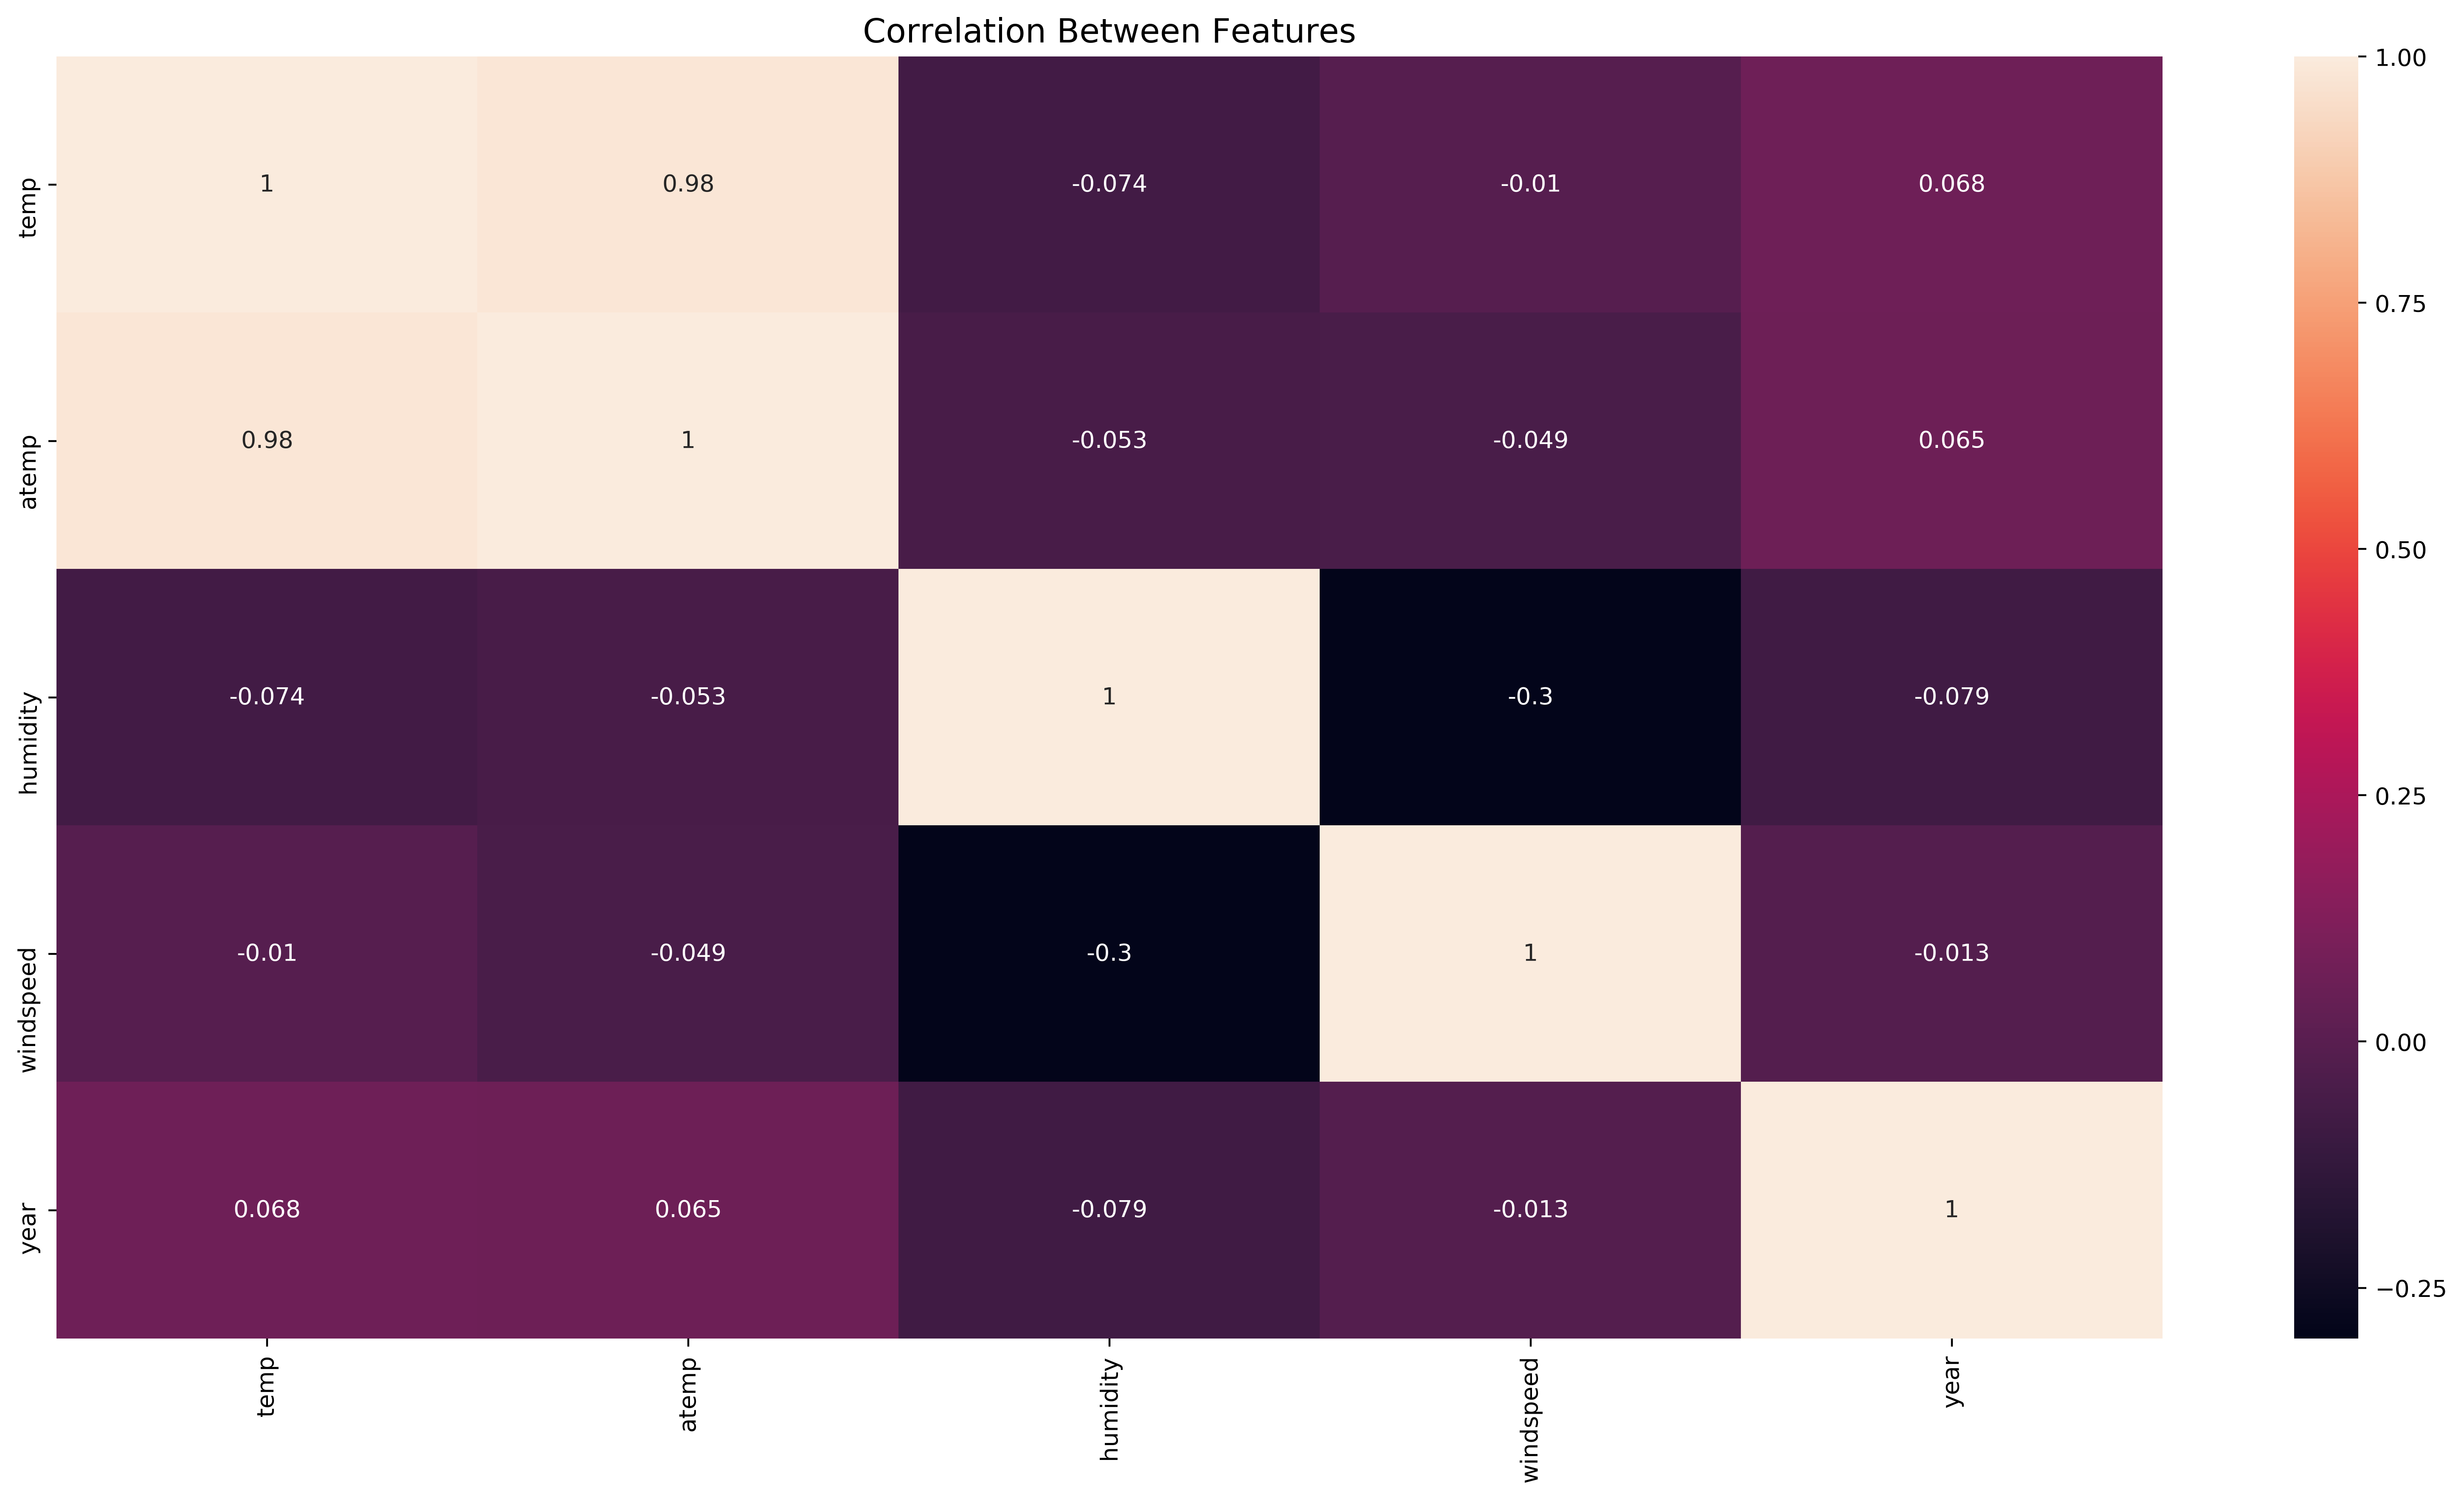

In [31]:
# visualize the correlation between remaining features
corr = train.corr()

plt.figure(figsize = (20,10), dpi= 400)
sns.heatmap(corr,annot=True)
plt.title("Correlation Between Features", fontsize = 14)
plt.xticks(rotation = 'vertical')
plt.savefig('correlation.jpg')
plt.show()

In [10]:
df_corr2 = train
for col in train:
  #print(col)
  for col_j in df_corr2:
    if(col != col_j):
      corr,_=spearmanr(train[col],train[col_j])
      if(corr > 0.5):
        print(col,',',col_j,',',corr)

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


temp , atemp , 0.9859981968668285
atemp , temp , 0.9859981968668287
hour , Total_bookings , 0.5174733152108004
Total_bookings , hour , 0.5174733152108003


temp and a temp seems to have high collinearity.

<Figure size 1440x3600 with 0 Axes>

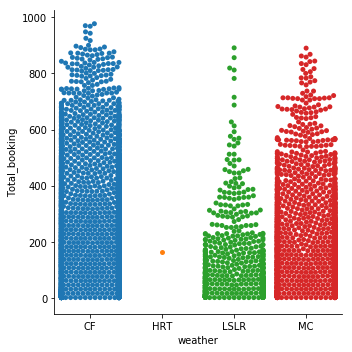

In [25]:
#weather_cf=train[train['weather']=='CF']
plt.figure(figsize =(20,50))
#sns.barplot(weather_cf['weather'],weather_cf['Total_booking'])
sns.catplot(x='weather',y='Total_booking',data=train,kind='swarm')

In [6]:
def get_outlier(df):
    features = df.columns
    outliers  = []
    for i, feature in enumerate(features):
        if df[feature].dtype == 'float64':
            # Calculate Q1 (25th percentile of the data) for the given feature
            Q1 = np.percentile(df[feature], 25)
            # Calculate Q3 (75th percentile of the data) for the given feature
            Q3 = np.percentile(df[feature], 75)
            # Use the interquartile range to calculate an outlier step
            step = 1.5 * (Q3 - Q1)
            feature_outliers = df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))]
            outliers.extend(list(feature_outliers.index.values))
            print('Feature Name: {}, No. of outliers: {}\n'.format(feature, len(feature_outliers.index)))
    
    multi_feature_outliers = (Counter(outliers) - Counter(set(outliers))).keys()
    #print(outliers)
    return outliers

In [7]:
from collections import Counter
multi_feature_outliers = get_outlier(train)

#max(windspeed_outiers),min(windspeed_outiers)

#windspeed_outiers=train.iloc[multi_feature_outliers]['windspeed']
train=train.drop(train.index[list(multi_feature_outliers)]).reset_index(drop=True)
train_laebl=train_laebl.drop(train_laebl.index[list(multi_feature_outliers)]).reset_index(drop=True)

Feature Name: temp, No. of outliers: 0

Feature Name: atemp, No. of outliers: 0

Feature Name: windspeed, No. of outliers: 182



In [8]:
def catgoricalencoding(df):
    cols_for_label_encoding=['season','weather','year','month','hour','day']
    dataset = pd.get_dummies(columns=cols_for_label_encoding, data=df)
    return dataset


In [9]:
dataset=catgoricalencoding(train)

Y=dataset['Total_bookings']

dataset.drop(['atemp','weather_HRT','Total_bookings'],axis=1,inplace=True)

SCALING DATA

In [10]:
def scaleData(dataset):
    standardScaler = StandardScaler()
    scaled_data = standardScaler.fit_transform(dataset[['humidity','temp','windspeed']])
    scaled_data_df=pd.DataFrame(scaled_data,columns=['humidity','temp','windspeed'])
    dataset[['humidity','temp','windspeed']] = scaled_data_df[['humidity','temp','windspeed']]
    return dataset

NORMALIZATION

In [12]:
normalize_data=normalize(dataset[['humidity','temp','windspeed']])

normalize_dataset=pd.DataFrame(normalize_data,columns=[['humidity','temp','windspeed']])

dataset[['humidity','temp','windspeed']] = normalize_dataset[['humidity','temp','windspeed']]

In [11]:
dataseta=scaleData(dataset)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [12]:
X_train, X_test,y_train, y_test = train_test_split(dataset,Y,test_size=0.3,random_state=2)

In [13]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5968, 69), (2558, 69), (5968,), (2558,))

In [14]:
linearModel=LinearRegression()

linearModel.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [15]:
linearModel.score(X_train,y_train)

0.6970404692311832

In [16]:
y_predict=linearModel.predict(X_test)

In [17]:
r2_score(y_test,y_predict) , mean_absolute_error(y_test,y_predict)

(0.7004137515122506, 73.6129773626857)

In [19]:
np.sqrt(mean_squared_error(y_test,y_predict))

99.74124376499212

TESTING WITH TEST DATA

In [20]:
test=pd.read_csv('test.csv')
test_label=pd.read_csv('test_label.csv',header=None)
datapreprocess(test)
test_data=catgoricalencoding(test)

In [21]:
test_data.drop(['atemp'],axis=1,inplace=True)
test_data=scaleData(test_data)



D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
total_booking_predict=linearModel.predict(test_data)

In [23]:
r2_score(test_label,total_booking_predict)

0.677924378708955